# Rare Disease Dataset: Monthly Article Traffic

This notebook contains code to construct, analyze, and publish a dataset of monthly article traffic for a select set of pages from English Wikipedia from July 1, 2015 through September 30, 2024.

## Access Page View Data

The following sub-section contains code to access page view data using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API). The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand this example.

### License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024

In [72]:
#
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

The example relies on some constants that help make the code a bit more readable.

In [73]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error
REQUEST_HEADERS = {
    'User-Agent': 'hnaidu36@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # start and end dates need to be set
    "end":         "2023040100"    # this is likely the wrong end date
}


The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [74]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


## Rare Disease Data Acquisition

IMPORTS

In [99]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

CONSTANTS

In [76]:
DEV_ENVIRONMENT = True
RARE_DISEASE_CSV_PATH = "rare-disease_cleaned.AUG.2024.csv"

START = "2015010100"
END = "2024093000"

In [77]:
START_DATE = START[0:-4]
END_DATE = END[0:-4]

desktop_views_file = f"rare-disease_monthly_desktop_{START_DATE}-{END_DATE}.json"
mobile_views_file = f"rare-disease_monthly_mobile_{START_DATE}-{END_DATE}.json"
cumulative_views_file = f"rare-disease_monthly_cumulative_{START_DATE}-{END_DATE}.json"

In [78]:
# Change the arguments of params templates
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['start'] = START
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['end'] = END

# Create access-specific params templates
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP['access'] = "desktop"

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB['access'] = "mobile-web"

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP['access'] = "mobile-app"

FUNCTIONS

In [79]:
def write_json_to_file(data, filename, mode = "a+"):
    with open(filename, mode) as json_file:
        json.dump(data, json_file, ensure_ascii=False)

In [80]:
def get_page_views_df_for_article(article_title = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS,
                                  headers = REQUEST_HEADERS):
    '''
    Get page views for a given article title.
    This drops the 'access' key from each of the response items.

    Parameters:
    ----------
    article_title: str
        The title of the article to get page views for
    
    endpoint_url: str
        The URL of the endpoint to make the request to

    request_template: dict
        The template for the request parameters
    
    endpoint_params: str
        The parameters for the request.
        These will be used to format the request_template

    headers: dict
        The headers to be used in the request
    
    Returns:
    -------
    response: pd.DataFrame
        The response from the API
        
    '''
    views = request_pageviews_per_article(article_title, endpoint_url, endpoint_params, request_template, headers)
    views = views['items']
    views_df = pd.DataFrame(views)
    views_df.drop(columns = ['access'], inplace = True)
    return views_df

### Load CSV

In [81]:
rare_disease_df = pd.read_csv(os.path.join(os.getcwd(), RARE_DISEASE_CSV_PATH))

views_desktop = {}
views_mobile = {}
views_cumulative = {}

In [82]:
rare_disease_df.count()

disease    1773
pageid     1773
url        1773
dtype: int64

In [83]:
rare_disease_df.head(1)

,disease,pageid,url
0,Klinefelter syndrome,19833554,https://en.wikipedia.org/wiki/Klinefelter_synd...


In [84]:
if DEV_ENVIRONMENT:
    rare_disease_df = rare_disease_df.head(20)

### Query API

In [85]:
# The following loop will make a request for each article in the list of article titles.
# The request returns a dataframe with the page views for the article.
# The dataframe is then stored as a JSON array in a dictionary with the article title as the key.
MERGE_COLUMNS = ["project", "article", "granularity","timestamp", "agent"]

for index, row in tqdm(rare_disease_df.iterrows(), total=rare_disease_df.shape[0]):
    article = row['disease']
    
    # Get desktop views
    views_desktop_df = get_page_views_df_for_article(article, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP)
    views_desktop[article] = json.loads(views_desktop_df.to_json(orient = "records"))

    # Get mobile views
    views_mobile_web_df = get_page_views_df_for_article(article, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
    views_mobile_app_df = get_page_views_df_for_article(article, request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)

    views_mobile_df = pd.merge(views_mobile_web_df, views_mobile_app_df, on=MERGE_COLUMNS, how = "outer", suffixes=('_df1', '_df2'))
    views_mobile_df['views'] = views_mobile_df['views_df1'].fillna(0) + views_mobile_df['views_df2'].fillna(0)
    views_mobile_df.drop(columns = ['views_df1', 'views_df2'], inplace = True)

    views_mobile[article] = json.loads(views_mobile_df.to_json(orient = "records"))

    # Get cumulative views
    views_cumulative_df = pd.merge(views_desktop_df, views_mobile_df, on=MERGE_COLUMNS, how = "outer", suffixes=('_df1', '_df2'))
    views_cumulative_df['views'] = views_cumulative_df['views_df1'].fillna(0) + views_cumulative_df['views_df2'].fillna(0)
    views_cumulative_df.drop(columns = ['views_df1', 'views_df2'], inplace = True)

    views_cumulative[article] = json.loads(views_cumulative_df.to_json(orient = "records"))

    if index+1 % 100 == 0:
        tqdm.write(f"Processed {index} articles")

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


### Write Views to Files

In [86]:
write_json_to_file(views_desktop, desktop_views_file, "w")
write_json_to_file(views_mobile, mobile_views_file, "w")
write_json_to_file(views_cumulative, cumulative_views_file, "w")

## Analysis

FUNCTIONS

In [87]:
def get_aggregates_for_article(views_df, article_title):
    '''
    Get the maximum, minimum, average and other values from views for an article

    Parameters:
    ----------
    views_df: pd.DataFrame
        The dataframe containing the views data for an article
    
    article_title: str
        The title of the article
    
    Returns:
    -------
    aggreate_views: dict
        A dictionary containing the maximum, minimum and average views for an article
    '''
    max_views = views_df['views'].max()
    max_month = views_df.loc[views_df['views'].idxmax()]['timestamp']
    min_views = views_df['views'].min()
    min_month = views_df.loc[views_df['views'].idxmin()]['timestamp']
    avg_views = views_df['views'].mean()
    count_views = views_df['views'].count()

    if article_title is None and views_df.shape[0] > 0:
        article_title = views_df['article'].iloc[0]

    aggregate_views = {
        'article': article_title,
        'max_views': max_views,
        'max_month': max_month,
        'min_views': min_views,
        'min_month': min_month,
        'avg_views': avg_views,
        'count_views': count_views
    }

    return aggregate_views

In [88]:
def get_article_with_max_views_average(aggregated_df):
    return aggregated_df.iloc[aggregated_df["avg_views"].idxmax()]

def get_article_with_min_views_average(aggregated_df):
    return aggregated_df.iloc[aggregated_df["avg_views"].idxmin()]

def get_top_10_peak_articles(aggregated_df):
    return aggregated_df.nlargest(10, 'max_views')

def get_top_10_lowest_articles(aggregated_df):
    return aggregated_df.nsmallest(10, 'min_views')

def get_lowest_count_articles(aggregated_df):
    return aggregated_df.nsmallest(10, 'count_views')

In [89]:
def get_aggregate_df_from_json_file(filename):
    '''
    Get the aggregate dataframe from a json file.

    The json file is expected to have article titles as keys and views data as values.

    Parameters:
    ----------
    filename: str
        The name of the json file to read from

    Returns:
    -------
    pd.DataFrame
        The aggregate dataframe from the json file
    '''
    aggregate_array = []

    with open(filename, "r") as json_file:
        views = json.load(json_file)
        for article_title, views_df in views.items():
            views_df = pd.DataFrame(views_df)
            aggregate_views = get_aggregates_for_article(views_df, article_title)
            aggregate_array.append(aggregate_views)
    
    return pd.DataFrame(aggregate_array)

In [118]:
def get_time_series_for_article_from_views(article_title, views):
    '''
    Get the page views time series for an article from the views data.
    Also, add an extra label to the views data.

    Parameters:
    ----------
    article_title: str
        The title of the article to get the dataframe for

    views: dict
        The dictionary containing the views data

    Returns:
    -------
    pd.DataFrame
        The views dataframe for the article
    '''
    views_df = pd.DataFrame(views[article_title])
    views_df['date'] = pd.to_datetime(views_df['timestamp'], format='%Y%m%d%H')
    return views_df

### Get Aggregate Dataframes Per Access Type

In [90]:
aggregate_desktop_df = get_aggregate_df_from_json_file(desktop_views_file)
aggregate_mobile_df = get_aggregate_df_from_json_file(mobile_views_file)
aggregate_cumulative_df = get_aggregate_df_from_json_file(cumulative_views_file)

In [91]:
aggregate_desktop_df.head(1)

,article,max_views,max_month,min_views,min_month,avg_views,count_views
0,Klinefelter syndrome,55026,2016020100,12060,2024070100,26221.738739,111


### Analysis Part 1

Plot a graph that contains time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series.

In [110]:
article_max_views_average_desktop = get_article_with_max_views_average(aggregate_desktop_df)
article_max_views_desktop = article_max_views_average_desktop['article']
article_min_views_average_desktop = get_article_with_min_views_average(aggregate_desktop_df)
article_min_views_desktop = article_min_views_average_desktop['article']

article_max_views_average_mobile = get_article_with_max_views_average(aggregate_mobile_df)
article_max_views_mobile = article_max_views_average_mobile['article']
article_min_views_average_mobile = get_article_with_min_views_average(aggregate_mobile_df)
article_min_views_mobile = article_min_views_average_mobile['article']

In [111]:
print(article_max_views_desktop, article_min_views_desktop)
print(article_max_views_mobile, article_min_views_mobile)

Klinefelter syndrome MT-TP
Dwarfism MT-TP


In [122]:
article_max_views_desktop_time_series = get_time_series_for_article_from_views(article_max_views_desktop, views_desktop)
article_min_views_desktop_time_series = get_time_series_for_article_from_views(article_min_views_desktop, views_desktop)

article_max_views_mobile_time_series = get_time_series_for_article_from_views(article_max_views_mobile, views_mobile)
article_min_views_mobile_time_series = get_time_series_for_article_from_views(article_min_views_mobile, views_mobile)

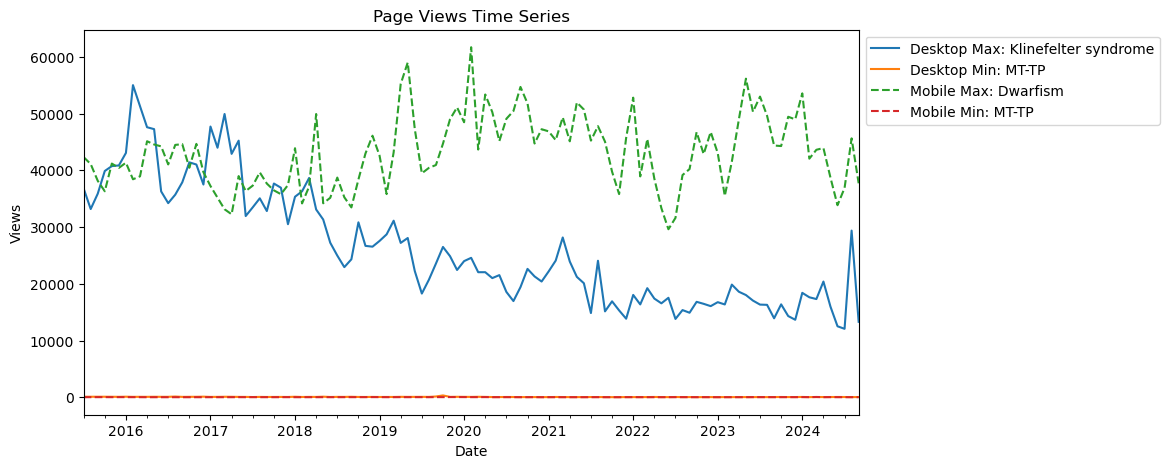

In [134]:
plt.figure(figsize=(10, 5))
ax = plt.gca()

article_max_views_desktop_time_series.plot(x='date', y='views', label='Desktop Max: '+article_max_views_desktop, ax=ax)
article_min_views_desktop_time_series.plot(x='date', y='views', label='Desktop Min: '+article_min_views_desktop, ax=ax)
article_max_views_mobile_time_series.plot(x='date', y='views', label='Mobile Max: '+article_max_views_mobile, ax=ax, linestyle='dashed')
article_min_views_mobile_time_series.plot(x='date', y='views', label='Mobile Min: '+article_min_views_mobile, ax=ax, linestyle='dashed')

plt.xlabel("Date")
plt.ylabel("Views")
plt.title("Page Views Time Series")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()